In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.appName("Mall Customers Analysis").getOrCreate()

In [4]:
print(spark.version)

3.5.1


In [7]:
#download the file from given Google drive link, and use the file path
df = spark.read.csv(r"C:\Users\Shivam\OneDrive\Desktop\CDE PROJECTS\MALL CUSTOMERS\Mall_Customers.csv", header=True, inferSchema=True)

###EXPLORE AND UNDERSTAND THE DATA FIRST-- using dataframe functions of pyspark

In [64]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- customerID: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- annual_income_kUSD: integer (nullable = true)
 |-- spending_score_1to100: integer (nullable = true)
 |-- age_group: string (nullable = false)



In [6]:
# Display the first few rows of the DataFrame
df.show(5)

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [7]:
# Get the column names
print(df.columns)

['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [8]:
# Get basic statistics of the numerical columns
df.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  NULL|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  NULL|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



###DATA CLEANING

In [9]:
#rename Genre to gender, Annual Income (k$) to annual_income_kUSD, Spending Score (1-100) to spending_score_1to100

df= df.withColumnRenamed("Genre", "gender") \
    .withColumnRenamed("Annual Income (k$)", "annual_income_kUSD")\
    .withColumnRenamed("Spending Score (1-100)", "spending_score_1to100")

df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- annual_income_kUSD: integer (nullable = true)
 |-- spending_score_1to100: integer (nullable = true)



In [10]:
print(df.columns)

['CustomerID', 'gender', 'Age', 'annual_income_kUSD', 'spending_score_1to100']


In [11]:
df= df.withColumnRenamed("CustomerID", "customerID") \
    .withColumnRenamed("Age", "age")
print(df.columns)

['customerID', 'gender', 'age', 'annual_income_kUSD', 'spending_score_1to100']


In [12]:
#calculate mode for Gender

from pyspark.sql.functions import col, count
mode= df.groupBy("gender").count().orderBy("gender", ascending=False).first()[0]
print(mode)

Male


In [13]:
#find the null values

for column in df.columns:
    null_value= df.filter(df[column].isNull()).count()
    print(f"Null values are: {column} - {null_value}")

Null values are: customerID - 0
Null values are: gender - 0
Null values are: age - 0
Null values are: annual_income_kUSD - 0
Null values are: spending_score_1to100 - 0


In [14]:
#since no null values found, no need to perform removal & replacement

In [8]:
#find duplicate values in customerID

from pyspark.sql.functions import col
duplicate_customerIDs = df.groupBy("customerID").count().filter(col("count") > 1)

duplicate_customerIDs.show()

+----------+-----+
|customerID|count|
+----------+-----+
+----------+-----+



In [ ]:
#no duplicate entry in customerID column

In [15]:
#remove invalid age entries

invalid_age = df.filter(col("Age") < 0).count()
print(invalid_age)

0


In [16]:
#since no invalid entries found, no need to perform removal

In [17]:
#remove invalid annual income entries

invalid_annual_income = df.filter(col("annual_income_kUSD") < 0).count()
print(invalid_annual_income)

0


In [18]:
#since no invalid entries found, no need to perform removal

In [40]:
!pip install seaborn


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

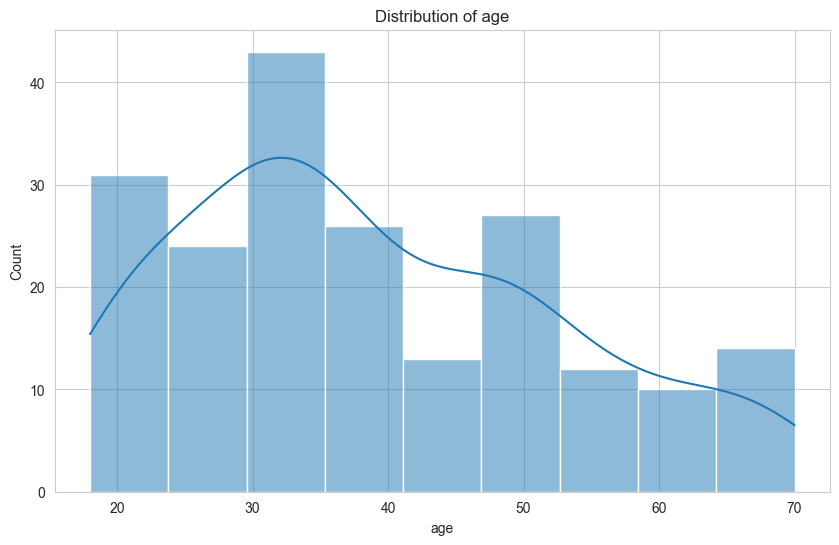

In [42]:
#Histogram of age
pandas_df = df.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="age", kde=True)
plt.title('Distribution of age')
plt.savefig('age_distribution.png')


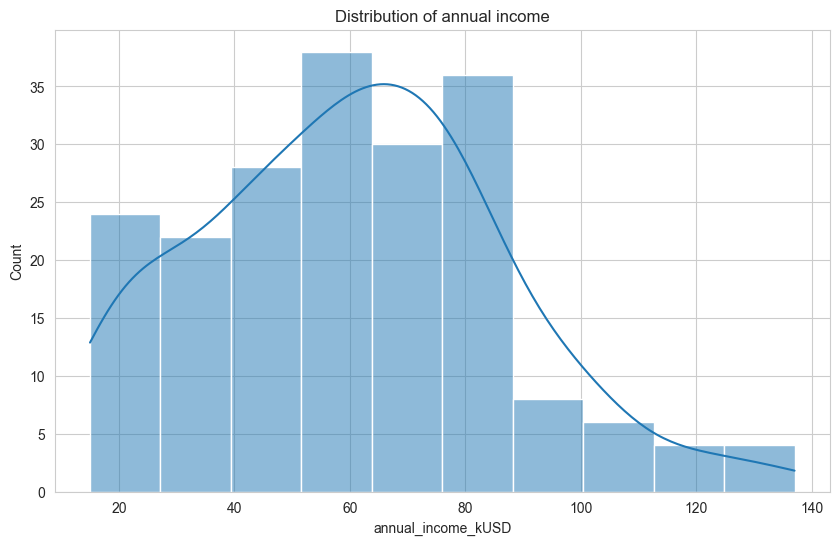

In [43]:
#Histogram of annual income

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="annual_income_kUSD", kde=True)
plt.title('Distribution of annual income')
plt.savefig('annual_income_distribution.png')


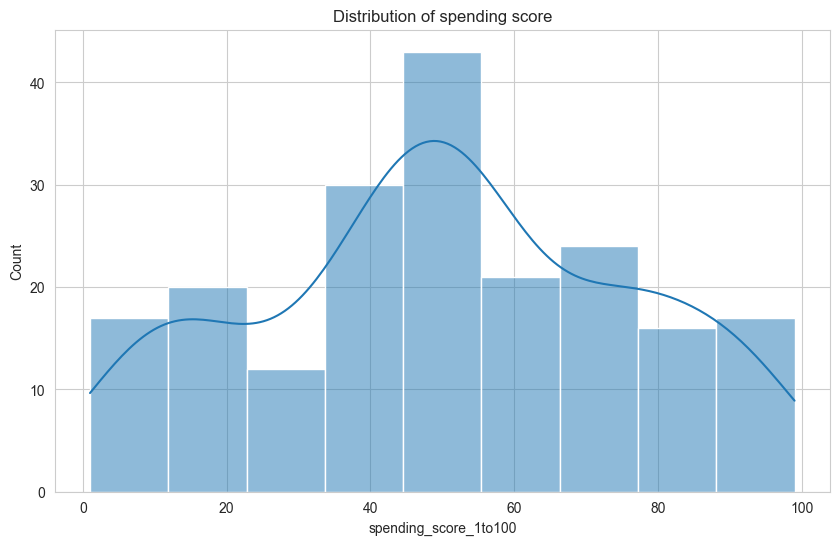

In [44]:
#Histogram of spending score

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="spending_score_1to100", kde=True)
plt.title('Distribution of spending score')
plt.savefig('spending_score_distribution.png')


###DATA MANIPULATION & ANALYSIS

In [45]:
#Distribution of Spending Score
df.select("spending_score_1to100").summary().show()

+-------+---------------------+
|summary|spending_score_1to100|
+-------+---------------------+
|  count|                  200|
|   mean|                 50.2|
| stddev|   25.823521668370173|
|    min|                    1|
|    25%|                   34|
|    50%|                   50|
|    75%|                   73|
|    max|                   99|
+-------+---------------------+



In [46]:
#Spending Score by Gender
df.groupBy("gender").agg({"spending_score_1to100": "avg"}).show()

+------+--------------------------+
|gender|avg(spending_score_1to100)|
+------+--------------------------+
|Female|        51.526785714285715|
|  Male|         48.51136363636363|
+------+--------------------------+



In [47]:
#Correlation between Age and Spending Score
from pyspark.sql.functions import corr
df.select(corr("age", "`spending_score_1to100`")).show()

+--------------------------------+
|corr(age, spending_score_1to100)|
+--------------------------------+
|            -0.32722684603909025|
+--------------------------------+



In [56]:
#Correlation between Annual Income and Spending Score
df.select(corr("`annual_income_kUSD`", "`spending_score_1to100`")).show()

+-----------------------------------------------+
|corr(annual_income_kUSD, spending_score_1to100)|
+-----------------------------------------------+
|                           0.009902848094037497|
+-----------------------------------------------+



In [67]:
# Age Group Analysis
df = df.withColumn("age_group", 
    when(col("age") < 26, "18-25")
    .when((col("age") >= 26) & (col("age") < 36), "26-35")
    .when((col("age") >= 36) & (col("age") < 46), "36-45")
    .when((col("age") >= 46) & (col("age") < 56), "46-55")
    .otherwise("56+"))
df.groupBy("age_group").agg({"Spending_Score_1to100": "avg"}).orderBy("age_group").show()

+---------+--------------------------+
|age_group|avg(Spending_Score_1to100)|
+---------+--------------------------+
|    18-25|         54.94736842105263|
|    26-35|                     64.45|
|    36-45|        44.833333333333336|
|    46-55|          36.7027027027027|
|      56+|         38.37931034482759|
+---------+--------------------------+



In [57]:
#Categorize Spending Score

from pyspark.sql.functions import when
df_categorized = df.withColumn("spending_category", 
    when(df["`spending_score_1to100`"] <= 20, "Low")
   .when((df["`spending_score_1to100`"] > 20) & (df["`spending_score_1to100`"] <= 50), "Medium")
   .otherwise("High"))
df_categorized.groupBy("spending_category").count().show()

+-----------------+-----+
|spending_category|count|
+-----------------+-----+
|             High|   97|
|              Low|   36|
|           Medium|   67|
+-----------------+-----+



In [59]:
#Average Annual Income by Spending Category
df_categorized.groupBy("spending_category").agg({"annual_income_kUSD": "avg"}).show()

+-----------------+-----------------------+
|spending_category|avg(annual_income_kUSD)|
+-----------------+-----------------------+
|             High|      60.41237113402062|
|              Low|      66.11111111111111|
|           Medium|     57.791044776119406|
+-----------------+-----------------------+



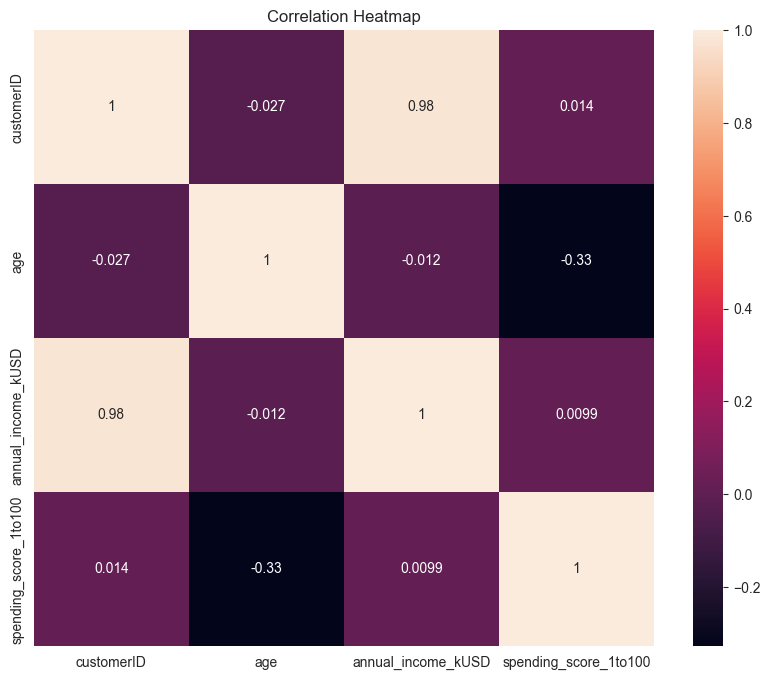

In [63]:
#correlations between all numerical variables

numeric_df = pandas_df._get_numeric_data()

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

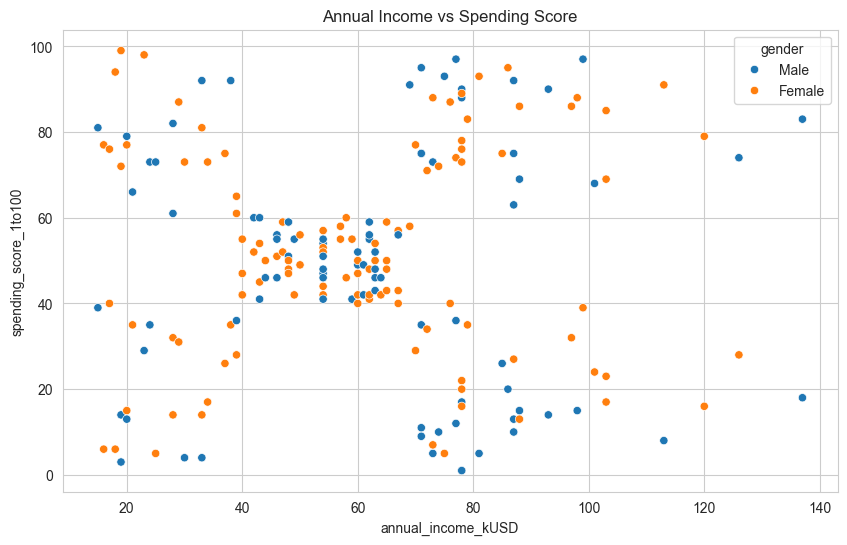

In [31]:
# Scatter plot of Annual Income vs Spending Score

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="annual_income_kUSD", y="spending_score_1to100", hue="gender")
plt.title('Annual Income vs Spending Score')
plt.savefig('income_vs_spending.png')

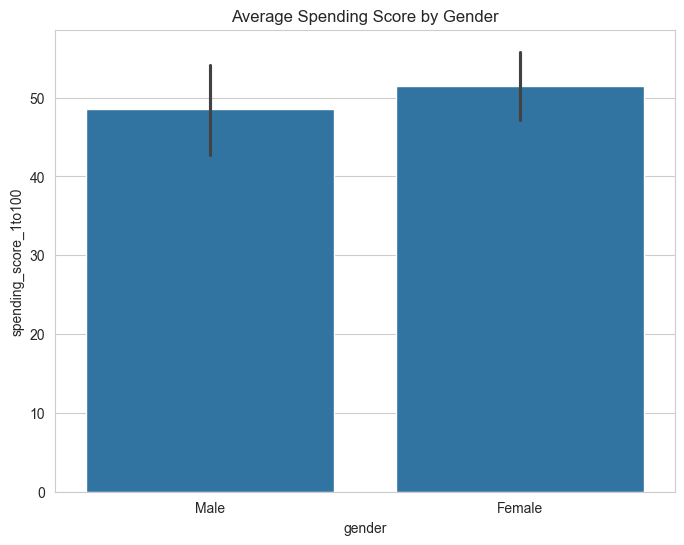

In [32]:
# Bar plot of Average Spending Score by Gender

plt.figure(figsize=(8, 6))
sns.barplot(data=pandas_df, x="gender", y="spending_score_1to100")
plt.title('Average Spending Score by Gender')
plt.savefig('gender_spending.png')